In [22]:
import mne
import mne_connectivity
from mne_connectivity import spectral_connectivity_time
from connection_complexity.data.raw_data.EDF.edf_helpers import read_edf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
eeg = read_edf('/media/dan/Data/data/iEEG/raw_ieeg/patientDumps/PC/OvertNaming.EDF', preload=True, drop_EEG_Prefix=True)

# set bads
# bads = ["TO'7"] # for patient PC
# eeg.info['bads'] = bads
# # remove 60hz + harmonics
# eeg = eeg.notch_filter(np.arange(60, 241, 60),verbose=False)
# eeg,_ = mne.set_eeg_reference(eeg, 'average', projection=False) # false applies it to the data; true makes a new channel

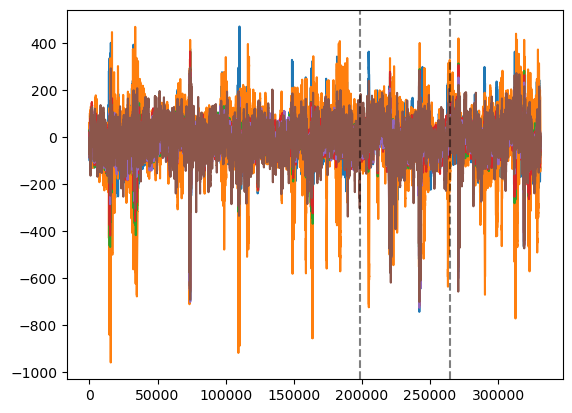

In [24]:
picks=["SP1","SP2","TO1","TO2","TO'1","TO'2"]
data = eeg.get_data(picks=picks) * 1e6 # convert to microvolts

# remove indexs corresponding to bad channels
# bad_inds = [eeg.ch_names.index(bad) for bad in bads]
# data = np.delete(data, bad_inds, axis=0)
plt.plot(data.T);

plt.axvline(198604, color='k', linestyle='--', alpha=0.5)
plt.axvline(264806, color='k', linestyle='--', alpha=0.5)

In [25]:
mean = np.mean(data, axis=1)
std = np.std(data, axis=1)
data = (data - mean[:, None]) / std[:, None]

In [26]:
test_start = 264806
normal = data[:,test_start:]

In [27]:
context = 32
a = test_start
b = a+context
# test_samples = normal[:,:context]
test_samples = data[:,a:b]

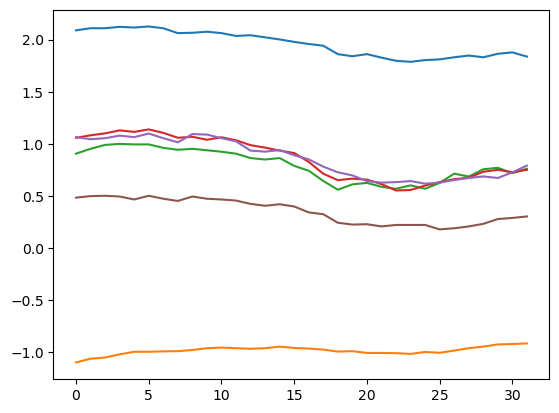

In [28]:
plt.plot(test_samples.T);

In [43]:
Fs = eeg.info['sfreq']

# amount of time to use in seconds
time_sec = 1
# cuteeg = data[:, 0:int(Fs*time_sec)]

# cut to beginning of val
cuteeg = data[:, :int(Fs*time_sec)]

# Define window length in milliseconds
N = 250

# Calculate the number of samples per window
samples_per_window = int((N / 1000) * Fs)
print(f"Samples per window: {samples_per_window}")

# Calculate the number of epochs
num_epochs = cuteeg.shape[1] // samples_per_window

# Reshape the array to create the new dimension for epochs
raweeg_epochs = np.reshape(cuteeg[:, :num_epochs * samples_per_window], (num_epochs, cuteeg.shape[0], samples_per_window))


Samples per window: 512


In [37]:
raweeg_epochs.shape

(4, 6, 512)

In [38]:
dur = float(samples_per_window) / Fs
cycle_freq = 7 / dur
cycle_freq

28.0

In [39]:
con = spectral_connectivity_time(
    raweeg_epochs,
    method="coh",
    mode="multitaper",
    sfreq=Fs,
    freqs = np.arange(30, 150, 1),
    faverage=True,
    n_jobs=40,
    verbose=False,
)

In [40]:
arr = con.get_data(output="dense").squeeze()

In [41]:
arr.shape

(4, 6, 6)

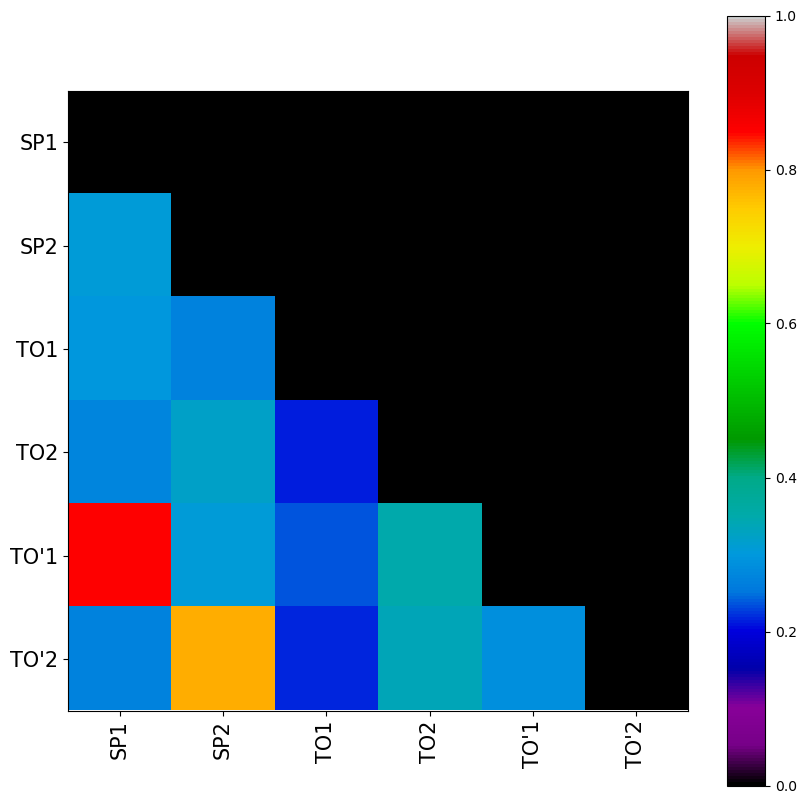

In [45]:
# plot matrix with channel labels on x and y axis and colorbar
idx = 0
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(arr[idx,...], cmap='nipy_spectral', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(picks)), picks, rotation=90, fontsize=15)
plt.yticks(range(len(picks)), picks, fontsize=15);


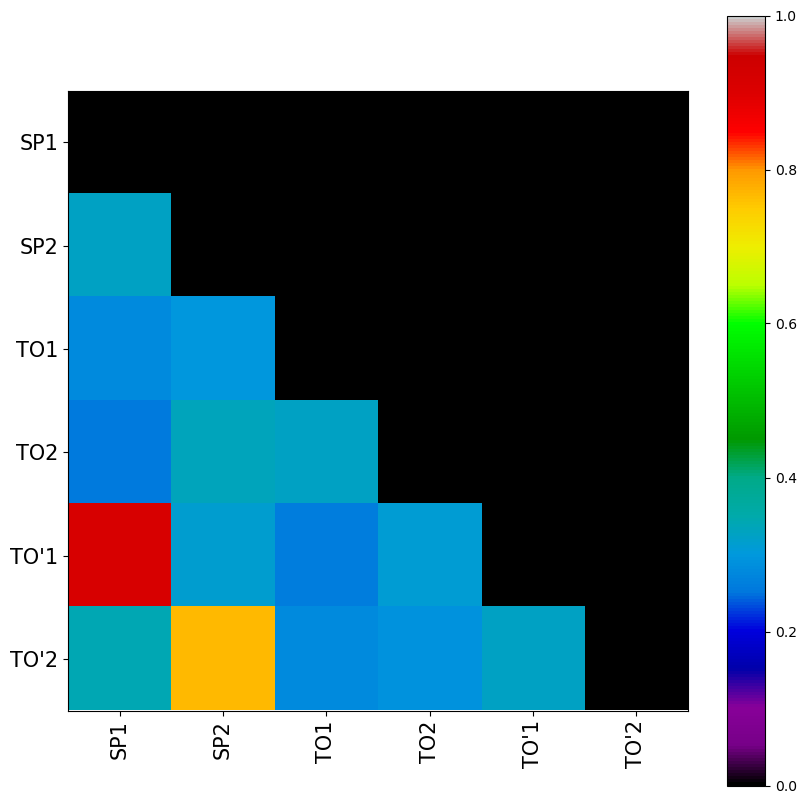

In [47]:
# plot matrix with channel labels on x and y axis and colorbar
mean = con.get_data(output="dense").squeeze().mean(axis=0)

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(mean, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(picks)), picks, rotation=90, fontsize=15)
plt.yticks(range(len(picks)), picks, fontsize=15);


In [49]:
dpli = spectral_connectivity_time(
    raweeg_epochs,
    method="wpli",
    mode="multitaper",
    sfreq=Fs,
    freqs = np.arange(30, 150, 1),
    faverage=True,
    n_jobs=40,
    verbose=False,
)

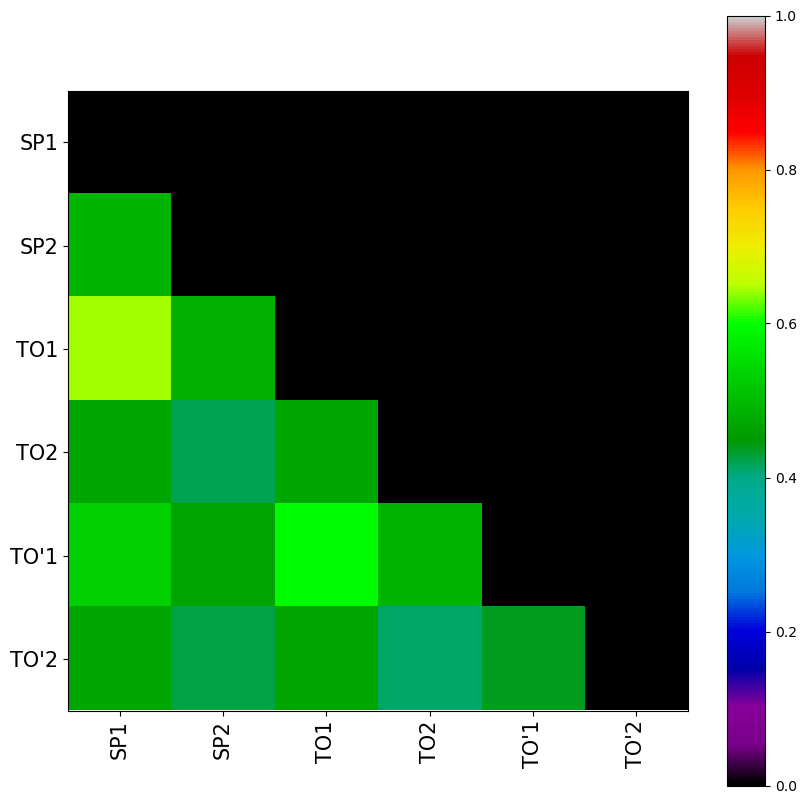

In [50]:
# plot matrix with channel labels on x and y axis and colorbar
mean = dpli.get_data(output="dense").squeeze().mean(axis=0)

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(mean, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=1)
plt.colorbar()
plt.xticks(range(len(picks)), picks, rotation=90, fontsize=15)
plt.yticks(range(len(picks)), picks, fontsize=15);


In [52]:
picks

['SP1', 'SP2', 'TO1', 'TO2', "TO'1", "TO'2"]

In [54]:
# get the indices of the lower triangle of the matrix
tril_inds = np.tril_indices(len(picks), k=-1)
# add diagonal indices
diag_inds = np.diag_indices(len(picks))
# combine the two
inds = np.concatenate((tril_inds, diag_inds), axis=1)
inds

array([[1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 0, 1, 2, 3, 4, 5],
       [0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5]])

In [55]:
dpli = spectral_connectivity_time(
    raweeg_epochs,
    method="gc",
    mode="multitaper",
    sfreq=Fs,
    freqs = np.arange(30, 150, 1),
    faverage=True,
    n_jobs=40,
    verbose=False,
    indices=inds,
)

ValueError: seed and target indices cannot contain repeated channels for multivariate connectivity